# Detecting network intrusions & anomalies with higher-order topological kernels via quantum computation 

### 0. CONSTRUCTING NUMPY DATASETS

In [95]:
import pandas as pd
import numpy as np

# Load the CSV (you may need to change this to your actual filename)
filename = 'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv'

# Load the first 50 rows
df = pd.read_csv(filename, nrows=500)

# Select the top 5 anomaly-related features
selected_features = [
    'total_payload_bytes',
    'bytes_rate',
    'packets_rate',
    'avg_segment_size',
    'duration',
    'fwd_bytes_rate',
    'bwd_bytes_rate',
    'syn_flag_counts'

]

# Extract the relevant features
features_df = df[selected_features]

# # Save as CSV
# features_df.to_csv('CSV-500-botnet-benign.csv', index=False)

# Save as a NumPy array
features_array = features_df.to_numpy()
np.save('500-botnet-attack.npy', features_array)


## BEGIN - TRAINING VECTORS & LOAD DATA

In [113]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel

In [114]:
qX1 = np.load('50-botnet-benign.npy')
qX2 = np.load('50-botnet-attack.npy')

In [115]:
qX1 = qX1[:10,:]
qX2 = qX2[:10,:]

In [116]:
# # Normalize
# qX1 = StandardScaler().fit_transform(qX1)
# qX2 = StandardScaler().fit_transform(qX2)

In [117]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(20, 8)
qy.shape=(20,)


In [118]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (16, 8) (16,)
Shape testing set: (4, 8) (4,)
Example of feature: [1.29500000e+03 2.31882842e+04 1.61154098e+02 1.43888889e+02
 5.58471680e-02 7.80702077e+03 1.53812634e+04 2.00000000e+00]
Example of label: -1


In [119]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

## BUILD QKERNEL

In [120]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
_service = QiskitRuntimeService()  # ensure credentials/configured
_backend = _service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")
_options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=_options,
        backend=_backend,
    )

/tmp/ipykernel_8984/3541412117.py:17: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  _service = QiskitRuntimeService()  # ensure credentials/configured


Add to Factory

In [ ]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
# KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
KernelFactory.set_current_implementation('qiskit_ibm')

In [122]:
# print(qX_train)
# print(qy_train)

Define ansatz ops

In [123]:
ansatz = Ansatz(n_features=8, n_qubits=8, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)

Create KernelFactory

In [ ]:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZZZZZ", KernelType.FIDELITY)

kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

In [125]:
# batch all jobs in a session
# with Session(backend=backend) as session:
#     kernel._session = session
#     kernel._sampler = Sampler(session=session)

#     K_train = kernel.build_kernel(X_train, X_train, matrix="train")


K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data
print(K_train)

[[ 1.00000000e+00 -6.55528899e-01 -8.15830557e-02 -7.14626267e-02
  -2.15170604e-01 -9.49416214e-02 -6.42104450e-02 -2.94967521e-02
  -8.77281021e-02  1.85274712e-02  4.19203799e-02 -4.15188614e-02
   1.24122643e-01  4.57344975e-02  1.89516119e-02 -5.53845998e-02]
 [-6.55528899e-01  1.00000000e+00 -6.62418798e-02  2.38117210e-02
   1.01506361e-02  5.10265375e-02 -1.05587550e-02  2.09989633e-01
   1.51944001e-01  1.18926241e-02 -2.19932002e-01 -5.02743298e-02
  -3.73434792e-01 -3.21805527e-02  3.10445128e-02 -1.39172675e-01]
 [-8.15830557e-02 -6.62418798e-02  1.00000000e+00  2.92904496e-01
   6.36112558e-01 -2.26349057e-01  7.20239147e-01  5.39582081e-01
  -2.28573798e-02 -4.69393651e-02  2.49017314e-03  8.91681572e-01
   6.01967354e-02  1.15052922e-02 -8.48955882e-01 -3.26523099e-01]
 [-7.14626267e-02  2.38117210e-02  2.92904496e-01  1.00000000e+00
   4.10177974e-01  4.14074486e-02  4.05052649e-01  1.06973616e-01
  -1.03625805e-01 -3.69629480e-02 -1.50065460e-01  1.52045055e-01
  -5.22

Fit trained data to model

In [126]:
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

In [127]:
# Predict the labels for the test data
K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
y_pred = model.predict(K_test)

In [128]:
# Calculate the accuracy
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


## Visualizations

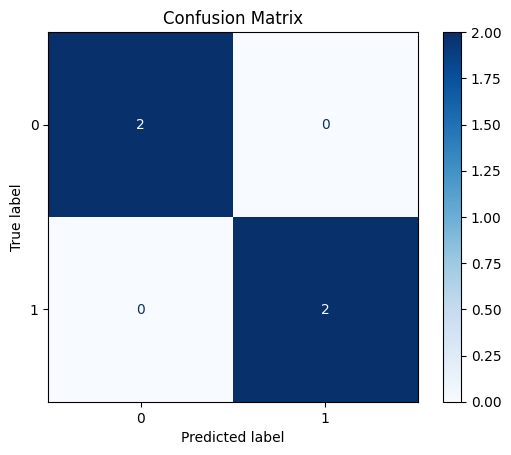

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()